In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

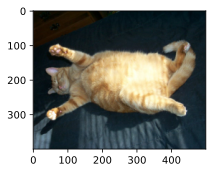

In [2]:
d2l.set_figsize()
img = d2l.Image.open('02_Data/cat1.jpg')  # 读取图片
d2l.plt.imshow(img)  # 显示图片

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):  # 传入aug图片增广方法
    Y = [aug(img) for _ in range(num_rows * num_cols)]  # 用aug方法对图片作用八次
    d2l.show_images(Y, num_rows, num_cols, scale=scale)  # 生成结果用num_cols行，num_cols列展示

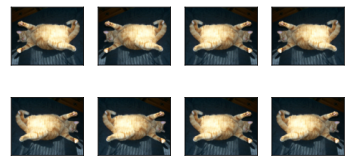

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())  # 水平随机翻转

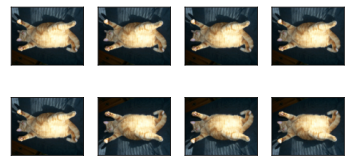

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())  # 上下随机翻转

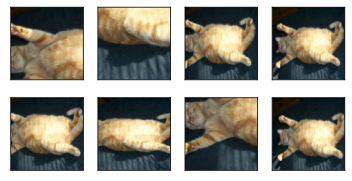

In [6]:
# 随机剪裁，剪裁后的大小为(200,200)
# (0.1,1)使得随即剪裁原始图片的10%到100%区域里的大小，ratio=(0.5,2)使得高宽比为2:1，下面是显示时显示的1:1
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

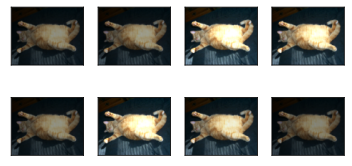

In [7]:
# 随即更改图像的亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

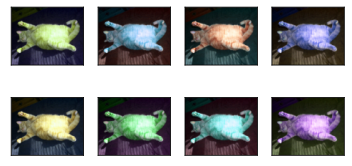

In [8]:
# 随机改变色调
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

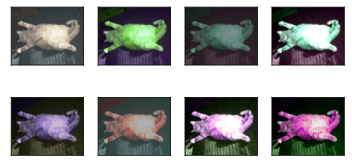

In [9]:
# 随机更改图像的亮度（brightness）、对比度（constrast）、饱和度（saturation）和色调（hue）
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

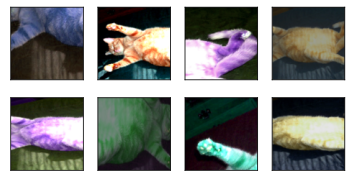

In [10]:
# 结合多种图像增广方法
# 先随即水平翻转，再做颜色增广，再做形状增广
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

100%|██████████| 170498071/170498071 [06:06<00:00, 465791.78it/s] 


Extracting 01_Data/03_CIFAR10\cifar-10-python.tar.gz to 01_Data/03_CIFAR10


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

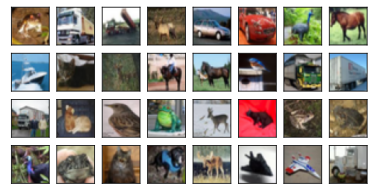

In [11]:
# 下载图片，并显示部分图片
all_images = torchvision.datasets.CIFAR10(train=True, root='01_Data/03_CIFAR10', download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [12]:
# 只使用最简单的随机左右翻转
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [13]:
# 定义一个辅助函数，以便于读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='01_Data/03_CIFAR10',train=is_train,
                                         transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train,
                                            num_workers = 0)
    return dataloader

In [14]:
# 定义一个函数，使用多GPU模式进行训练和评估
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X] # 如果X是一个list，则把数据一个接一个都挪到devices[0]上
    else:
        X = X.to(devices[0]) # 如果X不是一个list，则把X挪到devices[0]上
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],
                           legend=['train loss', 'train acc', 'test acc'])
    # nn.DataParallel使用多GPU
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc'
         f' {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f' {metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
         f' {str(devices)}')

In [16]:
# 定义train_with_data_aug函数，使用图像增广来训练模型
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10,3)

In [17]:
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [18]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    # Adam优化器算是一个比较平滑的SGD，它对学习率调参不是很敏感
    trainer = torch.optim.Adam(net.parameters(),lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\IDE\Anaconda\A\envs\dproject\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\boss\AppData\Local\Temp\ipykernel_4360\2206566086.py", line 1, in <module>
    train_with_data_aug(train_augs, test_augs, net)
  File "C:\Users\boss\AppData\Local\Temp\ipykernel_4360\4146320049.py", line 7, in train_with_data_aug
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
  File "C:\Users\boss\AppData\Local\Temp\ipykernel_4360\248785671.py", line 11, in train_ch13
    l, acc = train_batch_ch13(net,features,labels,loss,trainer,devices)
  File "C:\Users\boss\AppData\Local\Temp\ipykernel_4360\3523580434.py", line 10, in train_batch_ch13
    pred = net(X)
  File "D:\IDE\Anaconda\A\envs\dproject\lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "D:\IDE\Anaconda\A\envs\dproject

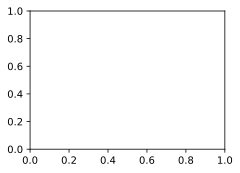

In [19]:
train_with_data_aug(train_augs, test_augs, net)